In [1]:
import zipfile
import pandas as pd
import numpy as np
import statsmodels.api as sm # !pip install statsmodels
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

## Womens

In [2]:
with zipfile.ZipFile('march-machine-learning-mania-2024.zip') as zf:
    print(zf.namelist())
    with zf.open('WRegularSeasonDetailedResults.csv') as f:
        df = pd.read_csv(f)
df.head()

['2024_tourney_seeds.csv', 'Cities.csv', 'Conferences.csv', 'MConferenceTourneyGames.csv', 'MGameCities.csv', 'MMasseyOrdinals.csv', 'MNCAATourneyCompactResults.csv', 'MNCAATourneyDetailedResults.csv', 'MNCAATourneySeedRoundSlots.csv', 'MNCAATourneySeeds.csv', 'MNCAATourneySlots.csv', 'MRegularSeasonCompactResults.csv', 'MRegularSeasonDetailedResults.csv', 'MSeasons.csv', 'MSecondaryTourneyCompactResults.csv', 'MSecondaryTourneyTeams.csv', 'MTeamCoaches.csv', 'MTeamConferences.csv', 'MTeamSpellings.csv', 'MTeams.csv', 'WGameCities.csv', 'WNCAATourneyCompactResults.csv', 'WNCAATourneyDetailedResults.csv', 'WNCAATourneySeeds.csv', 'WNCAATourneySlots.csv', 'WRegularSeasonCompactResults.csv', 'WRegularSeasonDetailedResults.csv', 'WSeasons.csv', 'WTeamConferences.csv', 'WTeamSpellings.csv', 'WTeams.csv', 'sample_submission.csv']


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,49,H,0,23,54,...,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,N,0,26,62,...,21,14,27,14,26,7,20,4,2,27
2,2010,11,3110,71,3224,59,A,0,29,62,...,14,19,23,17,23,8,15,6,0,15
3,2010,11,3111,63,3267,58,A,0,27,52,...,26,16,25,22,22,15,11,14,5,14
4,2010,11,3119,74,3447,70,H,1,30,74,...,17,11,21,21,32,12,14,4,2,14


In [3]:
with zipfile.ZipFile('march-machine-learning-mania-2024.zip') as zf:
    with zf.open('WRegularSeasonDetailedResults.csv') as f:
        W_Reg_Det = pd.read_csv(f)
    with zf.open('WNCAATourneyDetailedResults.csv') as f:
        W_NCAA_Det = pd.read_csv(f)
    with zf.open('WNCAATourneySeeds.csv') as f:
        seeds = pd.read_csv(f)
print(list(W_Reg_Det.columns.values))
W_Reg_Det.head()

['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,49,H,0,23,54,...,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,N,0,26,62,...,21,14,27,14,26,7,20,4,2,27
2,2010,11,3110,71,3224,59,A,0,29,62,...,14,19,23,17,23,8,15,6,0,15
3,2010,11,3111,63,3267,58,A,0,27,52,...,26,16,25,22,22,15,11,14,5,14
4,2010,11,3119,74,3447,70,H,1,30,74,...,17,11,21,21,32,12,14,4,2,14


In [4]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [5]:
w_reg_prep = prepare_data(W_Reg_Det)
w_ncaa_prep = prepare_data(W_NCAA_Det)

In [6]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']
w_ncaa_prepped = pd.merge(w_ncaa_prep, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
w_ncaa_prepped = pd.merge(w_ncaa_prepped, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
w_ncaa_prepped.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff,T1_seed,T2_seed
0,2010,138,3124,69,3201,55,0,0,28,57,...,17,19,12,18,4,1,18,14,4,13
1,2010,138,3173,67,3395,66,0,0,23,59,...,18,26,8,8,8,6,22,1,8,9
2,2010,138,3181,72,3214,37,1,0,26,57,...,10,21,4,16,6,4,20,35,2,15
3,2010,138,3199,75,3256,61,1,0,25,63,...,16,21,13,16,5,4,24,14,3,14
4,2010,138,3207,62,3265,42,0,0,24,68,...,16,22,9,10,3,4,12,20,5,12


In [7]:
boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [8]:
season_statistics = w_reg_prep.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,...,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2010,3102,19.142857,53.142857,4.571429,16.071429,12.464286,10.250000,17.714286,6.035714,...,27.000000,56.392857,7.714286,20.500000,12.821429,19.535714,14.392857,9.821429,5.035714,-19.964286
1,2010,3103,22.233333,55.266667,3.933333,12.466667,14.200000,13.433333,18.266667,8.033333,...,20.966667,54.966667,4.833333,15.166667,13.633333,11.700000,18.700000,9.233333,3.800000,2.600000
2,2010,3104,24.724138,62.103448,4.344828,14.724138,14.482759,13.103448,19.172414,7.379310,...,23.896552,60.137931,5.103448,16.517241,14.862069,12.517241,19.241379,8.758621,3.586207,-2.862069
3,2010,3105,20.370370,50.851852,3.037037,9.888889,13.666667,9.740741,25.037037,8.777778,...,22.777778,57.518519,3.740741,12.777778,15.185185,13.481481,20.740741,12.222222,4.407407,-3.962963
4,2010,3106,18.448276,53.000000,2.689655,9.586207,15.000000,11.482759,20.103448,8.034483,...,17.896552,50.689655,3.724138,11.827586,12.379310,9.517241,18.310345,8.793103,3.965517,-2.275862


In [9]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [10]:
w_ncaa_prepped = w_ncaa_prepped[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
w_ncaa_prepped = pd.merge(w_ncaa_prepped, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
w_ncaa_prepped = pd.merge(w_ncaa_prepped, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
w_ncaa_prepped.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2010,138,3124,69,3201,55,26.093750,56.343750,2.468750,8.656250,...,22.939394,56.696970,4.151515,13.848485,12.242424,11.848485,19.878788,6.757576,2.606061,12.878788
1,2010,138,3173,67,3395,66,25.884615,61.538462,5.461538,17.461538,...,21.833333,59.700000,5.733333,20.166667,14.866667,13.466667,20.666667,8.466667,3.500000,12.000000
2,2010,138,3181,72,3214,37,26.843750,63.750000,4.562500,14.468750,...,19.000000,49.933333,2.866667,10.333333,12.633333,8.733333,22.133333,6.633333,2.266667,7.700000
3,2010,138,3199,75,3256,61,26.400000,59.200000,6.100000,16.100000,...,23.903226,64.064516,4.806452,17.387097,13.709677,10.741935,17.451613,8.193548,4.225806,9.935484
4,2010,138,3207,62,3265,42,23.833333,60.266667,6.333333,20.066667,...,20.575758,58.939394,6.333333,21.363636,14.333333,10.727273,15.727273,7.151515,2.303030,10.272727


In [11]:
regular_season_effects = w_reg_prep[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
print(regular_season_effects.shape)
regular_season_effects.head()

(7322, 5)


,Season,T1_TeamID,T2_TeamID,PointDiff,win
0,2010,3173,3277,3,1
1,2010,3190,3151,24,1
2,2010,3329,3114,9,1
3,2010,3355,3211,4,1
4,2010,3436,3301,5,1


In [12]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']
w_ncaa_prepped = pd.merge(w_ncaa_prepped, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
w_ncaa_prepped = pd.merge(w_ncaa_prepped, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
w_ncaa_prepped["Seed_diff"] = w_ncaa_prepped["T1_seed"] - w_ncaa_prepped["T2_seed"]
w_ncaa_prepped

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_seed,T2_seed,Seed_diff
0,2010,138,3124,69,3201,55,26.093750,56.343750,2.468750,8.656250,...,13.848485,12.242424,11.848485,19.878788,6.757576,2.606061,12.878788,4,13,-9
1,2010,138,3173,67,3395,66,25.884615,61.538462,5.461538,17.461538,...,20.166667,14.866667,13.466667,20.666667,8.466667,3.500000,12.000000,8,9,-1
2,2010,138,3181,72,3214,37,26.843750,63.750000,4.562500,14.468750,...,10.333333,12.633333,8.733333,22.133333,6.633333,2.266667,7.700000,2,15,-13
3,2010,138,3199,75,3256,61,26.400000,59.200000,6.100000,16.100000,...,17.387097,13.709677,10.741935,17.451613,8.193548,4.225806,9.935484,3,14,-11
4,2010,138,3207,62,3265,42,23.833333,60.266667,6.333333,20.066667,...,21.363636,14.333333,10.727273,15.727273,7.151515,2.303030,10.272727,5,12,-7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1649,2023,147,3268,75,3376,86,28.741935,65.129032,6.838710,19.129032,...,15.562500,6.562500,8.031250,13.000000,5.656250,3.906250,30.343750,2,1,1
1650,2023,147,3326,74,3439,84,29.968750,64.531250,7.468750,21.937500,...,15.129032,7.064516,9.129032,13.354839,5.935484,3.129032,15.451613,3,1,2
1651,2023,151,3376,73,3234,77,30.718750,65.312500,4.406250,14.000000,...,23.937500,8.250000,13.812500,13.843750,8.375000,2.906250,16.187500,1,2,-1
1652,2023,151,3439,72,3261,79,25.967742,57.451613,7.741935,22.193548,...,19.800000,8.133333,10.266667,16.866667,7.200000,3.600000,26.366667,1,3,-2


['T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean', 'T1_opponent_FGA3mean', 'T1_opponent_ORmean', 'T1_opponent_Astmean', 'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean', 'T1_PointDiffmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean', 'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean', 'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean', 'T2_opponent_FGM3mean', 'T2_opponent_FGA3mean', 'T2_opponent_ORmean', 'T2_opponent_Astmean', 'T2_opponent_TOmean', 'T2_opponent_Stlmean', 'T2_opponent_Blkmean', 'T2_PointDiffmean', 'T1_seed', 'T2_seed']


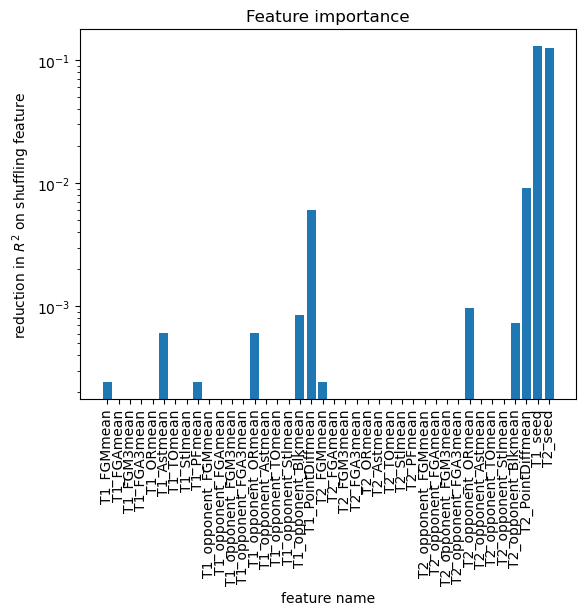

In [13]:
# find the best womens features
features = list(season_statistics_T1.columns[2:]) + \
    list(season_statistics_T2.columns[2:]) + \
    list(seeds_T1.columns[2:]) + \
    list(seeds_T2.columns[2:]) + \
    ["Seed_diff"]

# features = list(w_ncaa_prepped.columns)
features.remove("Seed_diff")
# features.remove("T2_Score")
# features.remove("T1_Score")
print(features)
X = w_ncaa_prepped[features]
y = w_ncaa_prepped["T1_Score"] > w_ncaa_prepped["T2_Score"]
m1 = XGBClassifier(reg_alpha = 0.2, reg_lambda = 1.0)
m1.fit(X, y)
pi = permutation_importance(estimator=m1, X=X, y=y, random_state=0)
plt.bar(x=range(X.columns.size), height=pi.importances_mean, tick_label=X.columns)
plt.yscale("log")
plt.title('Feature importance')
plt.xlabel('feature name')
plt.ylabel(r'reduction in $R^2$ on shuffling feature')
plt.xticks(rotation=90)
plt.show()

In [14]:
features_refined = list(["T1_FGMmean", "T1_FGAmean", "T1_Astmean", "T1_opponent_FGMmean", "T1_opponent_FGAmean", "T1_opponent_ORmean", "T1_opponent_Blkmean", "T1_PointDiffmean", "T2_FGMmean", "T2_FGAmean", "T2_Astmean", "T2_opponent_FGMmean", "T2_opponent_FGAmean", "T2_opponent_ORmean", "T2_opponent_Blkmean", "T2_PointDiffmean", "T1_seed", "T2_seed", "Seed_diff"])

train = w_ncaa_prepped[w_ncaa_prepped['Season'] < 2020]
test = w_ncaa_prepped[w_ncaa_prepped['Season'] > 2020]
Xtrain = train[features_refined]
ytrain = train['T1_Score'] > train['T2_Score']
Xtest = test[features_refined]
ytest = test['T1_Score'] > test['T2_Score']

In [15]:
m1 = XGBClassifier()
m1.fit(Xtrain, ytrain)
predictions = m1.predict_proba(Xtest)

In [16]:
output = pd.DataFrame(predictions[:,1], columns = ['Predictions'])
output['Actual'] = ytest.astype(int).reset_index(drop=True)
output["Score"] = (output["Actual"] - output["Predictions"])**2
output["Score"].mean()

0.2159394515767871

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.1, 0.01, 0.001, 0.0005]
}

grid_search = GridSearchCV(estimator=m1, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(Xtrain, ytrain)

best_params = grid_search.best_params_

In [18]:
best_params

{'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1}

In [19]:
m2 = XGBClassifier(reg_alpha = 0.15, reg_lambda = 0.01, **best_params)

m2.fit(Xtrain, ytrain)
predictions2 = m2.predict_proba(Xtest)

output = pd.DataFrame(predictions2[:,1], columns = ['Predictions'])
output['Actual'] = ytest.astype(int).reset_index(drop=True)
output["Score"] = (output["Actual"] - output["Predictions"])**2
output["Score"].mean()

0.1755059644631429

In [20]:
train

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_seed,T2_seed,Seed_diff
0,2010,138,3124,69,3201,55,26.093750,56.343750,2.468750,8.656250,...,13.848485,12.242424,11.848485,19.878788,6.757576,2.606061,12.878788,4,13,-9
1,2010,138,3173,67,3395,66,25.884615,61.538462,5.461538,17.461538,...,20.166667,14.866667,13.466667,20.666667,8.466667,3.500000,12.000000,8,9,-1
2,2010,138,3181,72,3214,37,26.843750,63.750000,4.562500,14.468750,...,10.333333,12.633333,8.733333,22.133333,6.633333,2.266667,7.700000,2,15,-13
3,2010,138,3199,75,3256,61,26.400000,59.200000,6.100000,16.100000,...,17.387097,13.709677,10.741935,17.451613,8.193548,4.225806,9.935484,3,14,-11
4,2010,138,3207,62,3265,42,23.833333,60.266667,6.333333,20.066667,...,21.363636,14.333333,10.727273,15.727273,7.151515,2.303030,10.272727,5,12,-7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,2019,147,3234,53,3124,85,30.687500,59.125000,5.656250,16.343750,...,24.500000,10.031250,9.406250,14.937500,5.593750,2.250000,25.937500,2,1,1
1453,2019,147,3390,68,3323,84,27.781250,61.875000,8.906250,25.343750,...,21.393939,13.818182,13.484848,16.424242,7.151515,3.272727,25.000000,2,1,1
1454,2019,151,3332,67,3124,72,31.937500,63.625000,9.750000,23.343750,...,24.500000,10.031250,9.406250,14.937500,5.593750,2.250000,25.937500,2,1,1
1455,2019,151,3163,76,3323,81,31.000000,62.818182,7.757576,21.575758,...,21.393939,13.818182,13.484848,16.424242,7.151515,3.272727,25.000000,2,1,1


## Predicting on the actual data

In [21]:
# read the data
all_matchups = pd.read_csv("2024_Potential_Matchups.csv", index_col = 0)
womens_matchups = all_matchups[all_matchups["T1_ID"] >= 3000]
mens_matchups = all_matchups[(all_matchups["T2_ID"] >= 1000) & (all_matchups["T2_ID"] <= 2000)]
print(len(womens_matchups))
print(len(mens_matchups))

2278
2278


In [22]:
# combine it with this seasons stats
ss1 = season_statistics[season_statistics["Season"] == 2024].copy()
ss2 = season_statistics[season_statistics["Season"] == 2024].copy()
ss1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
ss2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
ss1.columns = [x.replace("T1_TeamID", "T1_ID") for x in list(season_statistics_T1.columns)]
ss2.columns = [x.replace("T2_TeamID", "T2_ID") for x in list(season_statistics_T2.columns)]
womens_final = pd.merge(womens_matchups, ss1, on = ['T1_ID'], how = 'left')
womens_final = pd.merge(womens_final, ss2, on = ['T2_ID'], how = 'left')
womens_final.columns = [x.replace("_Seed", "_seed") for x in list(womens_final.columns)]
womens_final["Seed_diff"] = womens_final["T1_seed"] - womens_final["T2_seed"]
# womens_final.drop([1])
womens_final

,T1_Spelling,T1_ID,T1_seed,T2_Spelling,T2_ID,T2_seed,Season_x,T1_FGMmean,T1_FGAmean,T1_FGM3mean,...,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,Seed_diff
0,south carolina,3376,1,usc,3425,1,2024,33.666667,66.666667,6.666667,...,56.653846,5.461538,17.884615,7.653846,13.115385,15.076923,5.884615,2.423077,13.269231,0
1,south carolina,3376,1,texas,3400,1,2024,33.666667,66.666667,6.666667,...,55.200000,5.500000,17.866667,7.433333,11.266667,19.200000,6.966667,2.266667,24.133333,0
2,south carolina,3376,1,iowa,3234,1,2024,33.666667,66.666667,6.666667,...,65.689655,7.344828,24.620690,8.793103,13.448276,14.448276,7.068966,2.862069,21.241379,0
3,south carolina,3376,1,ohio state,3326,2,2024,33.666667,66.666667,6.666667,...,56.000000,5.259259,17.962963,8.148148,11.814815,20.185185,5.740741,2.370370,18.000000,-1
4,south carolina,3376,1,notre dame,3323,2,2024,33.666667,66.666667,6.666667,...,61.259259,5.111111,18.777778,9.074074,12.296296,19.185185,7.925926,4.370370,19.185185,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,presbyterian,3342,16,ut martin,3404,16,2024,21.259259,53.037037,5.592593,...,57.846154,7.076923,22.038462,9.807692,14.923077,14.115385,8.307692,4.230769,-0.538462,0
2274,presbyterian,3342,16,a&m-corpus christi,3394,16,2024,21.259259,53.037037,5.592593,...,59.000000,5.227273,19.818182,10.136364,12.363636,16.727273,8.909091,2.636364,4.045455,0
2275,drexel,3180,16,ut martin,3404,16,2024,22.500000,57.541667,3.875000,...,57.846154,7.076923,22.038462,9.807692,14.923077,14.115385,8.307692,4.230769,-0.538462,0
2276,drexel,3180,16,a&m-corpus christi,3394,16,2024,22.500000,57.541667,3.875000,...,59.000000,5.227273,19.818182,10.136364,12.363636,16.727273,8.909091,2.636364,4.045455,0


In [23]:
# run the model and add the predictions back into the dataframe
test_data = womens_final[features_refined]
predictions = m2.predict_proba(test_data)
output = pd.DataFrame(predictions[:,1], columns = ['Predictions'])
womens_matchups["Predictions"] = output 
len(womens_matchups[womens_matchups["Predictions"] < 0.5])
# better or same seeds are always listed under T1 in the dataset, 
#    so the number of predicted losses will be much lower

# wait to export the file until you have both mens and womens predictions

C:\Users\Mayag\AppData\Local\Temp\ipykernel_24040\973290752.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  womens_matchups["Predictions"] = output


45

## Mens

In [24]:
with zipfile.ZipFile('march-machine-learning-mania-2024.zip') as zf:
    print(zf.namelist())
    with zf.open('MRegularSeasonDetailedResults.csv') as f:
        df_mens = pd.read_csv(f)
df_mens.head()

['2024_tourney_seeds.csv', 'Cities.csv', 'Conferences.csv', 'MConferenceTourneyGames.csv', 'MGameCities.csv', 'MMasseyOrdinals.csv', 'MNCAATourneyCompactResults.csv', 'MNCAATourneyDetailedResults.csv', 'MNCAATourneySeedRoundSlots.csv', 'MNCAATourneySeeds.csv', 'MNCAATourneySlots.csv', 'MRegularSeasonCompactResults.csv', 'MRegularSeasonDetailedResults.csv', 'MSeasons.csv', 'MSecondaryTourneyCompactResults.csv', 'MSecondaryTourneyTeams.csv', 'MTeamCoaches.csv', 'MTeamConferences.csv', 'MTeamSpellings.csv', 'MTeams.csv', 'WGameCities.csv', 'WNCAATourneyCompactResults.csv', 'WNCAATourneyDetailedResults.csv', 'WNCAATourneySeeds.csv', 'WNCAATourneySlots.csv', 'WRegularSeasonCompactResults.csv', 'WRegularSeasonDetailedResults.csv', 'WSeasons.csv', 'WTeamConferences.csv', 'WTeamSpellings.csv', 'WTeams.csv', 'sample_submission.csv']


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [25]:
with zipfile.ZipFile('march-machine-learning-mania-2024.zip') as zf:
    with zf.open('MRegularSeasonDetailedResults.csv') as f:
        M_Reg_Det = pd.read_csv(f)
    with zf.open('MNCAATourneyDetailedResults.csv') as f:
        M_NCAA_Det = pd.read_csv(f)
    with zf.open('MNCAATourneySeeds.csv') as f:
        seeds = pd.read_csv(f)

In [26]:
M_NCAA_Det.columns.values

array(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore',
       'WLoc', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA',
       'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA',
       'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO',
       'LStl', 'LBlk', 'LPF'], dtype=object)

In [27]:
M_Reg_Det.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [28]:
m_reg_prep = prepare_data(M_Reg_Det)
m_ncaa_prep = prepare_data(M_NCAA_Det)

m_ncaa_prep.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,...,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,...,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,...,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,...,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,...,15,20,10,26,16,14,5,8,19,2


In [29]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']
m_ncaa_prepped = pd.merge(m_ncaa_prep, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
m_ncaa_prepped = pd.merge(m_ncaa_prepped, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
m_ncaa_prepped.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff,T1_seed,T2_seed
0,2003,134,1421,92,1411,84,0,1,32,69,...,17,28,16,15,5,0,22,8,16,16
1,2003,136,1112,80,1436,51,0,0,31,66,...,8,26,12,17,10,3,15,29,1,16
2,2003,136,1113,84,1272,71,0,0,31,59,...,20,22,11,12,2,5,18,13,10,7
3,2003,136,1141,79,1166,73,0,0,29,53,...,14,17,20,21,6,6,21,6,11,6
4,2003,136,1143,76,1301,74,0,1,27,64,...,10,26,16,14,5,8,19,2,8,9


In [30]:
season_statistics = m_reg_prep.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,...,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,...,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,...,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,...,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,...,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,...,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [31]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [32]:
m_ncaa_prepped = m_ncaa_prepped[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
m_ncaa_prepped = pd.merge(m_ncaa_prepped, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
m_ncaa_prepped = pd.merge(m_ncaa_prepped, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
m_ncaa_prepped.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000


In [33]:
regular_season_effects = m_reg_prep[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
print(regular_season_effects.shape)
regular_season_effects.head()

(11692, 5)


,Season,T1_TeamID,T2_TeamID,PointDiff,win
0,2003,1104,1328,6,1
1,2003,1272,1393,7,1
2,2003,1323,1237,44,1
3,2003,1242,1221,24,1
4,2003,1390,1462,1,1


In [34]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']
m_ncaa_prepped = pd.merge(m_ncaa_prepped, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
m_ncaa_prepped = pd.merge(m_ncaa_prepped, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
m_ncaa_prepped["Seed_diff"] = m_ncaa_prepped["T1_seed"] - m_ncaa_prepped["T2_seed"]
m_ncaa_prepped

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_seed,T2_seed,Seed_diff
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,16,16,0
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,1,16,-15
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,10,7,3
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,11,6,5
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,8,9,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,2023,146,1400,81,1274,88,28.205882,60.176471,7.147059,21.088235,...,22.531250,8.281250,14.312500,12.187500,5.968750,3.281250,7.281250,2,5,-3
2626,2023,146,1166,56,1361,57,27.515152,58.878788,8.909091,24.757576,...,21.968750,7.312500,10.750000,12.156250,6.312500,2.937500,7.531250,6,5,1
2627,2023,152,1274,59,1163,72,28.968750,59.625000,7.593750,20.656250,...,16.484848,6.969697,9.151515,12.666667,6.666667,2.878788,13.424242,5,4,1
2628,2023,152,1194,71,1361,72,27.906250,59.593750,9.718750,26.093750,...,21.968750,7.312500,10.750000,12.156250,6.312500,2.937500,7.531250,9,5,4


['T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean', 'T1_opponent_FGA3mean', 'T1_opponent_ORmean', 'T1_opponent_Astmean', 'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean', 'T1_PointDiffmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean', 'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean', 'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean', 'T2_opponent_FGM3mean', 'T2_opponent_FGA3mean', 'T2_opponent_ORmean', 'T2_opponent_Astmean', 'T2_opponent_TOmean', 'T2_opponent_Stlmean', 'T2_opponent_Blkmean', 'T2_PointDiffmean', 'T1_seed', 'T2_seed']


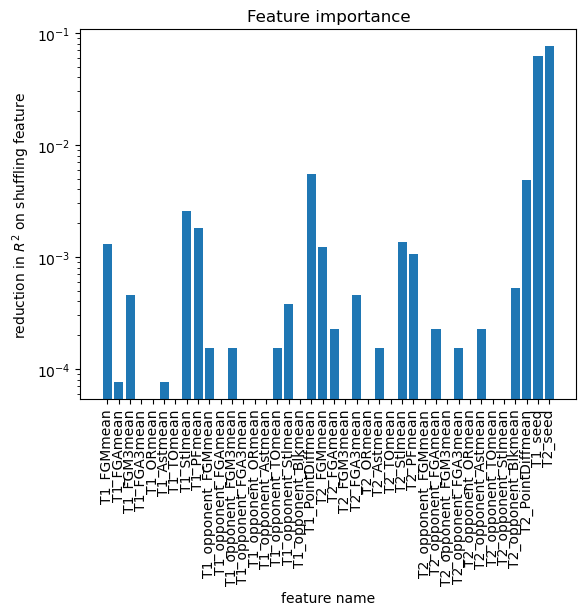

In [35]:
# find the best mens features
features = list(season_statistics_T1.columns[2:]) + \
    list(season_statistics_T2.columns[2:]) + \
    list(seeds_T1.columns[2:]) + \
    list(seeds_T2.columns[2:]) + \
    ["Seed_diff"]

# features = list(w_ncaa_prepped.columns)
features.remove("Seed_diff")
# features.remove("T2_Score")
# features.remove("T1_Score")
print(features)
X = m_ncaa_prepped[features]
y = m_ncaa_prepped["T1_Score"] > m_ncaa_prepped["T2_Score"]
m1 = XGBClassifier(reg_alpha = 0.2, reg_lambda = 1.0)
m1.fit(X, y)
pi = permutation_importance(estimator=m1, X=X, y=y, random_state=0)
plt.bar(x=range(X.columns.size), height=pi.importances_mean, tick_label=X.columns)
plt.yscale("log")
plt.title('Feature importance')
plt.xlabel('feature name')
plt.ylabel(r'reduction in $R^2$ on shuffling feature')
plt.xticks(rotation=90)
plt.show()

In [36]:
features_refined = list(["T1_FGMmean", "T1_FGAmean", "T1_FGM3mean", "T1_FGA3mean", "T1_PFmean", "T1_opponent_FGAmean", "T1_opponent_Stlmean", "T1_opponent_TOmean", "T1_PointDiffmean", "T2_FGMmean", "T2_FGAmean", "T2_FGM3mean", "T2_FGA3mean", "T2_PFmean", "T2_opponent_FGAmean", "T2_opponent_Stlmean", "T2_opponent_TOmean", "T2_PointDiffmean", "T1_seed", "T2_seed", "Seed_diff"])

train = m_ncaa_prepped[m_ncaa_prepped['Season'] < 2020]
test = m_ncaa_prepped[m_ncaa_prepped['Season'] > 2020]
Xtrain = train[features_refined]
ytrain = train['T1_Score'] > train['T2_Score']
Xtest = test[features_refined]
ytest = test['T1_Score'] > test['T2_Score']

In [37]:
m1 = XGBClassifier()
m1.fit(Xtrain, ytrain)
predictions = m1.predict_proba(Xtest)

In [38]:
output = pd.DataFrame(predictions[:,1], columns = ['Predictions'])
output['Actual'] = ytest.astype(int).reset_index(drop=True)
output["Score"] = (output["Actual"] - output["Predictions"])**2
output["Score"].mean()

0.2637085884944698

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.1, 0.01, 0.001, 0.0005]
}

grid_search = GridSearchCV(estimator=m1, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(Xtrain, ytrain)

best_params = grid_search.best_params_

In [40]:
best_params

{'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5}

In [41]:
m2 = XGBClassifier(reg_alpha = 0.15, reg_lambda = 0.01, **best_params)

m2.fit(Xtrain, ytrain)
predictions2 = m2.predict_proba(Xtest)

output = pd.DataFrame(predictions2[:,1], columns = ['Predictions'])
output['Actual'] = ytest.astype(int).reset_index(drop=True)
output["Score"] = (output["Actual"] - output["Predictions"])**2
output["Score"].mean()

0.2182897622519233

## Predicting on the actual data

In [42]:
# read the data earlier
# combine with the season stats
ss1 = season_statistics[season_statistics["Season"] == 2024].copy()
ss2 = season_statistics[season_statistics["Season"] == 2024].copy()
ss1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
ss2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
ss1.columns = [x.replace("T1_TeamID", "T1_ID") for x in list(season_statistics_T1.columns)]
ss2.columns = [x.replace("T2_TeamID", "T2_ID") for x in list(season_statistics_T2.columns)]
mens_final = pd.merge(mens_matchups, ss1, on = ['T1_ID'], how = 'left')
mens_final = pd.merge(mens_final, ss2, on = ['T2_ID'], how = 'left')
mens_final.columns = [x.replace("_Seed", "_seed") for x in list(mens_final.columns)]
mens_final["Seed_diff"] = mens_final["T1_seed"] - mens_final["T2_seed"]
mens_final

,T1_Spelling,T1_ID,T1_seed,T2_Spelling,T2_ID,T2_seed,Season_x,T1_FGMmean,T1_FGAmean,T1_FGM3mean,...,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,Seed_diff
0,uconn,1163,1,north carolina,1314,1,2024,28.857143,58.357143,8.714286,...,62.214286,7.000000,22.857143,7.142857,10.250000,10.250000,5.678571,3.785714,11.107143,0
1,uconn,1163,1,houston,1222,1,2024,28.857143,58.357143,8.714286,...,49.464286,6.142857,20.500000,8.178571,11.464286,15.285714,4.750000,2.857143,17.714286,0
2,uconn,1163,1,purdue,1345,1,2024,28.857143,58.357143,8.714286,...,62.464286,7.571429,23.464286,7.750000,14.750000,9.607143,6.785714,2.250000,14.750000,0
3,uconn,1163,1,arizona,1112,2,2024,28.857143,58.357143,8.714286,...,63.000000,8.285714,24.500000,7.214286,14.285714,13.071429,6.678571,3.464286,16.964286,-1
4,uconn,1163,1,iowa state,1235,2,2024,28.857143,58.357143,8.714286,...,51.035714,7.750000,23.250000,7.892857,12.428571,17.035714,6.107143,3.464286,14.928571,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,howard,1224,16,montana state,1286,16,2024,25.000000,55.769231,7.961538,...,56.320000,6.320000,19.640000,8.320000,12.840000,12.560000,6.040000,2.760000,-2.800000,0
2274,howard,1224,16,wagner,1447,16,2024,25.000000,55.769231,7.961538,...,53.500000,6.500000,21.333333,7.791667,13.791667,10.375000,4.916667,3.375000,-1.750000,0
2275,longwood,1255,16,montana state,1286,16,2024,25.884615,58.576923,5.615385,...,56.320000,6.320000,19.640000,8.320000,12.840000,12.560000,6.040000,2.760000,-2.800000,0
2276,longwood,1255,16,wagner,1447,16,2024,25.884615,58.576923,5.615385,...,53.500000,6.500000,21.333333,7.791667,13.791667,10.375000,4.916667,3.375000,-1.750000,0


In [43]:
# run the model and add the predictions back into the dataframe
test_data = mens_final[features_refined]
predictions = m2.predict_proba(test_data)
output = pd.DataFrame(predictions[:,1], columns = ['Predictions'])
mens_matchups["Predictions"] = output 
len(mens_matchups[mens_matchups["Predictions"] < 0.5])
# better or same seeds are always listed under T1 in the dataset, 
#    so the number of predicted losses will be much lower

C:\Users\Mayag\AppData\Local\Temp\ipykernel_24040\3270863050.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mens_matchups["Predictions"] = output


301

In [44]:
# export the new dataframe as a csv file
final_data = pd.concat([womens_matchups, mens_matchups])
final_data.to_csv('final_data.csv')

In [45]:
len(final_data)

4556